--- Cargando y Preparando Datos ---
Primeras filas del dataset:
   year  month  day  week  temp_2  temp_1  average  actual  forecast_noaa  \
0  2016      1    1   Fri      45      45     45.6      45             43   
1  2016      1    2   Sat      44      45     45.7      44             41   
2  2016      1    3   Sun      45      44     45.8      41             43   
3  2016      1    4   Mon      44      41     45.9      40             44   
4  2016      1    5  Tues      41      40     46.0      44             46   

   forecast_acc  forecast_under  friend  
0            50              44      29  
1            50              44      61  
2            46              47      56  
3            48              46      53  
4            46              46      41  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  


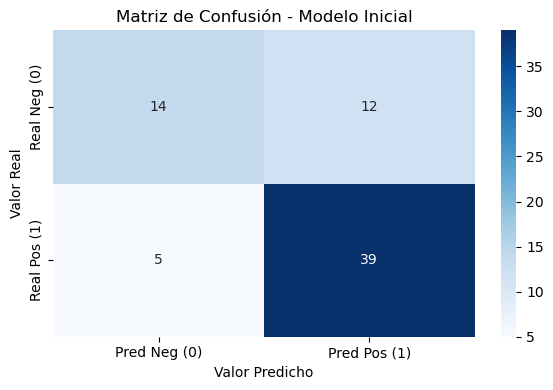


Reporte de Clasificación inicial:
              precision    recall  f1-score   support

           0       0.74      0.54      0.62        26
           1       0.76      0.89      0.82        44

    accuracy                           0.76        70
   macro avg       0.75      0.71      0.72        70
weighted avg       0.75      0.76      0.75        70


Área Bajo la Curva ROC (AUC) inicial: 0.7465


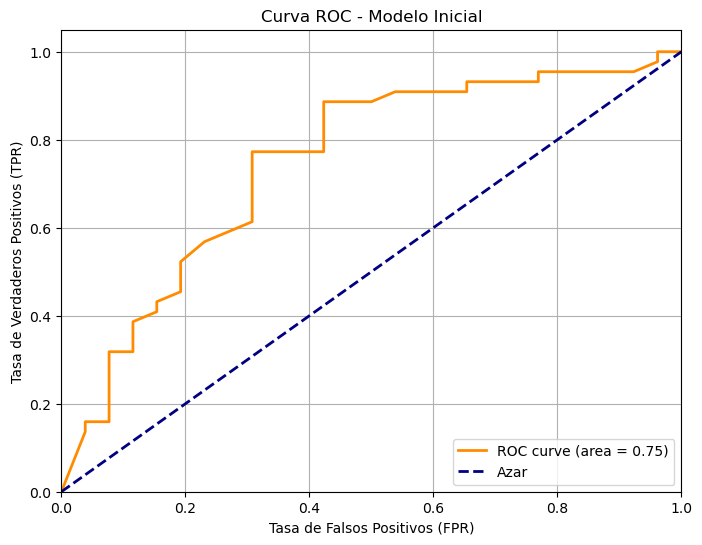


--- Importancia de Características (Modelo Inicial) ---
Importancia de cada característica:
   feature  importance
0  average    0.416111
1   temp_1    0.317502
2   temp_2    0.266388


C:\Users\arann\AppData\Local\Temp\ipykernel_17632\4667685.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_df, palette='viridis')


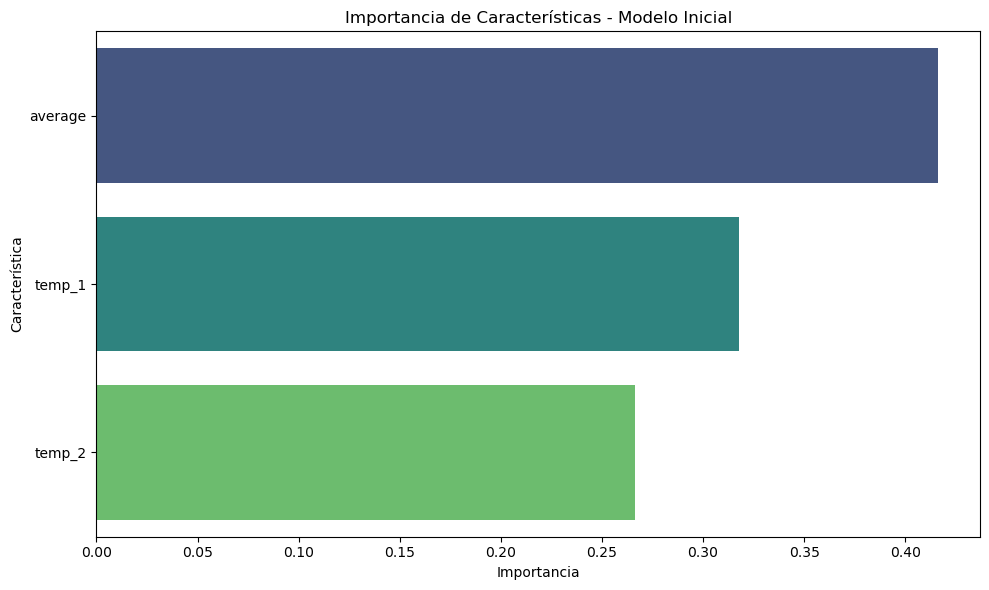


--- Optimizando Hiperparámetros con Grid Search ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Mejores parámetros encontrados: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}

Mejor puntuación (AUC) en validación cruzada: 0.7748

--- Evaluando Modelo Optimizado ---
Precisión (Accuracy) optimizada: 0.7286 (Inicial: 0.7571)

Matriz de Confusión optimizada:
[[16 10]
 [ 9 35]]


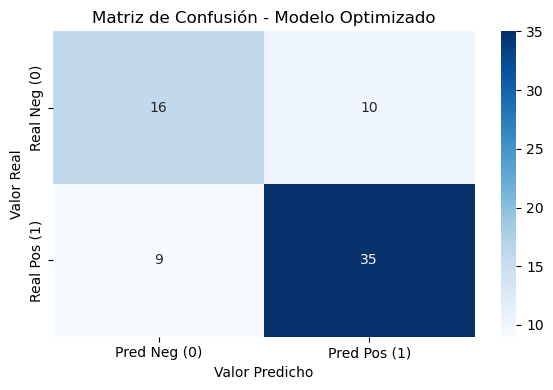


Reporte de Clasificación optimizado:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        26
           1       0.78      0.80      0.79        44

    accuracy                           0.73        70
   macro avg       0.71      0.71      0.71        70
weighted avg       0.73      0.73      0.73        70


Área Bajo la Curva ROC (AUC) optimizada: 0.7614 (Inicial: 0.7465)


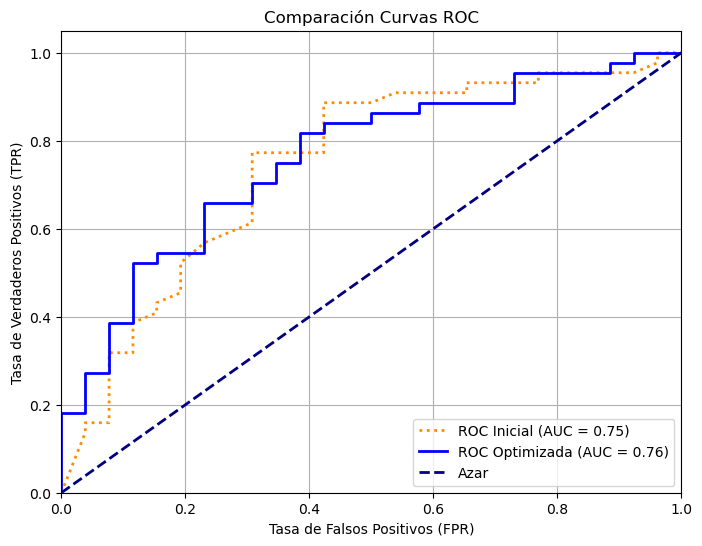


--- Discusión y Explicación ---

**¿Cómo la aleatoriedad y el uso de múltiples árboles mejoran el rendimiento y la generalización?**

Random Forest introduce aleatoriedad de dos maneras principales:
1.  **Bagging (Bootstrap Aggregating):** Cada árbol del bosque se entrena con una muestra aleatoria del conjunto de datos original, tomada con reemplazo (bootstrap sample). Esto significa que algunos datos pueden aparecer varias veces en la muestra de un árbol y otros pueden no aparecer (estos últimos forman el Out-of-Bag sample, útil para evaluación interna). Esto diversifica los árboles, ya que cada uno ve una perspectiva ligeramente diferente de los datos.
2.  **Aleatoriedad de Características (Feature Subsampling):** Al decidir la mejor división en cada nodo de un árbol, Random Forest no considera todas las características disponibles, sino solo un subconjunto aleatorio de ellas. Esto evita que unas pocas características muy predictivas dominen la estructura de todos los árboles, forza

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Carga y Preparación de Datos
print("--- Cargando y Preparando Datos ---")

# Cargar el dataset
df = pd.read_csv('temps.csv')

print("Primeras filas del dataset:")
print(df.head())
print("\nInformación del dataset:")
df.info()

# Feature Engineering: Crear variable objetivo binaria para clasificación
# Asumimos que queremos predecir si la temperatura actual fue mayor que la media historica
# Si 'actual' o 'average' no existen, generara KeyError.
df['target'] = (df['actual'] > df['average']).astype(int)
print(f"\nDistribución de la variable objetivo 'target':\n{df['target'].value_counts()}")

# Preprocesamiento básico
# Eliminar filas con valores NaN (si las hubiera en las columnas que usaremos)
# Si alguna de estas columnas no existe, generará KeyError.
df_clean = df.dropna(subset=['temp_2', 'temp_1', 'average', 'actual', 'target'])

# Seleccionar caracteristicas (features) y variable objetivo (target)
# Usaremos temperaturas previas y la media como caracteristicas
features = ['temp_2', 'temp_1', 'average']
X = df_clean[features]
y = df_clean['target']

# Obtener los nombres de las caracteristicas para usarlos mas tarde
feature_list = list(X.columns)

# Dividir los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify es bueno para clasificacion

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

# Entrenar un Modelo Random Forest Inicial
print("\n--- Entrenando Modelo Random Forest Inicial ---")
# Instanciar el modelo con parámetros por defecto o iniciales razonables
# n_estimators: numero de arboles en el bosque
# random_state: para reproducibilidad
rf_initial = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True) # oob_score=True permite evaluar con Out-of-Bag samples

# Entrenar el modelo
rf_initial.fit(X_train, y_train)

print(f"Precisión Out-of-Bag inicial: {rf_initial.oob_score_:.4f}")

# Evaluar el Modelo Inicial en el Conjunto de Prueba
print("\n--- Evaluando Modelo Inicial ---")
# Realizar predicciones en el conjunto de prueba
y_pred_initial = rf_initial.predict(X_test)
y_pred_proba_initial = rf_initial.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva (necesario para ROC)

# Calcular metricas
accuracy_initial = accuracy_score(y_test, y_pred_initial)
cm_initial = confusion_matrix(y_test, y_pred_initial)
report_initial = classification_report(y_test, y_pred_initial)

print(f"Precisión (Accuracy) inicial: {accuracy_initial:.4f}")
print("\nMatriz de Confusión inicial:")
print(cm_initial)
# Visualizar Matriz de Confusion
plt.figure(figsize=(6, 4))
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Neg (0)', 'Pred Pos (1)'], yticklabels=['Real Neg (0)', 'Real Pos (1)'])
plt.title('Matriz de Confusión - Modelo Inicial')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación inicial:")
print(report_initial)

# Calcular Curva ROC y AUC
fpr_initial, tpr_initial, thresholds_initial = roc_curve(y_test, y_pred_proba_initial)
roc_auc_initial = auc(fpr_initial, tpr_initial)

print(f"\nÁrea Bajo la Curva ROC (AUC) inicial: {roc_auc_initial:.4f}")

# Visualizar Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_initial, tpr_initial, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_initial:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Inicial')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Extraer y Visualizar Importancia de Caracteristicas
print("\n--- Importancia de Características (Modelo Inicial) ---")
# Obtener la importancia
importances = rf_initial.feature_importances_
# Crear un DataFrame para mejor visualización
feature_importances_df = pd.DataFrame({'feature': feature_list, 'importance': importances})
# Ordenar por importancia descendente
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False).reset_index(drop=True)

print("Importancia de cada característica:")
print(feature_importances_df)

# Visualizar la importancia de las caracteristicas
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df, palette='viridis')
plt.title('Importancia de Características - Modelo Inicial')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Busqueda en Cuadricula (Grid Search) para Optimizar Hiperparámetros
print("\n--- Optimizando Hiperparámetros con Grid Search ---")
# Definir la cuadricula de parametros a probar
# n_estimators: Numero de arboles
# max_depth: Profundidad maxima de cada arbol
# min_samples_split: Número mínimo de muestras para dividir un nodo
# min_samples_leaf: Número mínimo de muestras en un nodo hoja
param_grid = {
    'n_estimators': [50, 100, 200],        # Probar diferentes numeros de arboles
    'max_depth': [None, 5, 10, 15],         # Probar diferentes profundidades (None = sin límite)
    'min_samples_split': [2, 5, 10],      # Probar diferentes minimos para dividir
    'min_samples_leaf': [1, 3, 5]         # Probar diferentes minimos por hoja
    } # 'max_features': ['auto', 'sqrt', 'log2'] # Podrias añadir mas hiperparametros


# Instanciar el modelo base (sin entrenar)
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced') # class_weight='balanced' puede ayudar si hay desbalance

# Configurar Grid Search
# cv=5: Validacion cruzada de 5 folds
# scoring='roc_auc': Métrica a optimizar (AUC es buena para clasificacion binaria)
# n_jobs=-1: Usar todos los procesadores disponibles
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc', verbose=1) # verbose>0 muestra progreso

# Ejecutar la busqueda en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parametros y el mejor estimador
print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_
print(f"\nMejor puntuación (AUC) en validación cruzada: {grid_search.best_score_:.4f}")


#Evaluar el Modelo Optimizado
print("\n--- Evaluando Modelo Optimizado ---")
# Realizar predicciones con el mejor modelo encontrado
y_pred_best = best_rf.predict(X_test)
y_pred_proba_best = best_rf.predict_proba(X_test)[:, 1]

# Calcular metricas del modelo optimizado
accuracy_best = accuracy_score(y_test, y_pred_best)
cm_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Precisión (Accuracy) optimizada: {accuracy_best:.4f} (Inicial: {accuracy_initial:.4f})")
print("\nMatriz de Confusión optimizada:")
print(cm_best)
# Visualizar Matriz de Confusion
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Neg (0)', 'Pred Pos (1)'], yticklabels=['Real Neg (0)', 'Real Pos (1)'])
plt.title('Matriz de Confusión - Modelo Optimizado')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación optimizado:")
print(report_best)

# Calcular Curva ROC y AUC del modelo optimizado
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

print(f"\nÁrea Bajo la Curva ROC (AUC) optimizada: {roc_auc_best:.4f} (Inicial: {roc_auc_initial:.4f})")

# Visualizar Curva ROC Optimizada (y comparar con la inicial)
plt.figure(figsize=(8, 6))
plt.plot(fpr_initial, tpr_initial, color='darkorange', lw=2, linestyle=':', label=f'ROC Inicial (AUC = {roc_auc_initial:.2f})')
plt.plot(fpr_best, tpr_best, color='blue', lw=2, label=f'ROC Optimizada (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Discusión y Explicacion
print("\n--- Discusión y Explicación ---")

print("""
**¿Cómo la aleatoriedad y el uso de múltiples árboles mejoran el rendimiento y la generalización?**

Random Forest introduce aleatoriedad de dos maneras principales:
1.  **Bagging (Bootstrap Aggregating):** Cada árbol del bosque se entrena con una muestra aleatoria del conjunto de datos original, 
tomada con reemplazo (bootstrap sample). Esto significa que algunos datos pueden aparecer varias veces en la muestra de un árbol y 
otros pueden no aparecer (estos últimos forman el Out-of-Bag sample, útil para evaluación interna). Esto diversifica los árboles, 
ya que cada uno ve una perspectiva ligeramente diferente de los datos.
2.  **Aleatoriedad de Características (Feature Subsampling):** Al decidir la mejor división en cada nodo de un árbol, Random Forest 
no considera todas las características disponibles, sino solo un subconjunto aleatorio de ellas. Esto evita que unas pocas características 
muy predictivas dominen la estructura de todos los árboles, forzando al modelo a considerar también otras características potencialmente 
útiles.

El uso de múltiples árboles (un "bosque") permite promediar las predicciones de todos los árboles individuales (en clasificación, 
suele ser por voto mayoritario). Los árboles individuales pueden tener alta varianza (ser muy sensibles a los datos específicos 
con los que fueron entrenados) y tender al sobreajuste. Sin embargo, al promediar las predicciones de muchos árboles descorrelacionados 
(gracias a la aleatoriedad introducida), la varianza del modelo conjunto se reduce significativamente, mejorando la **generalización** 
(rendimiento en datos no vistos) y haciéndolo más robusto.

**Ventajas del Random Forest frente a un único árbol de decisión:**

1. Reducción del Sobreajuste (Overfitting):** Esta es la ventaja principal. Un árbol de decisión único, especialmente si es profundo, 
puede ajustarse perfectamente a los datos de entrenamiento, incluyendo el ruido, lo que lleva a un mal rendimiento en datos nuevos. 
Random Forest, al promediar muchos árboles construidos sobre diferentes subconjuntos de datos y características, reduce drásticamente 
esta tendencia al sobreajuste.
2. Mayor Precisión y Robustez:** Generalmente, los Random Forests ofrecen una mayor precisión predictiva que los árboles de decisión 
individuales. También son más robustos a los valores atípicos (outliers) y al ruido en los datos debido al proceso de promediado.
3. No requiere Poda (Pruning) explícita:** Mientras que los árboles de decisión a menudo necesitan ser podados para controlar el 
sobreajuste, en Random Forest, el control se logra principalmente a través del número de árboles y la aleatoriedad en la selección de 
características y muestras.
4. Manejo Implícito de Selección de Características:** El método proporciona una medida de la importancia de las características 
(`feature_importances_`), que ayuda a entender qué variables son más influyentes en la predicción.
5. Buena performance "out-of-the-box":** A menudo funciona bien con la configuración de hiperparámetros por defecto, aunque la 
optimización (como hicimos con Grid Search) puede mejorar aún más el rendimiento.
""")
